## Enviroment: 
Open AI gym [MountainCar-v0](https://github.com/openai/gym/wiki/MountainCar-v0)

### Observation
Type: Box(2)

| Num  | Observation | Min   | Max  |
| ---- | ----------- | ----- | ---- |
| 0    | position    | -1.2  | 0.6  |
| 1    | velocity    | -0.07 | 0.07 |

### Actions

Type: Discrete(3)

| Num  | Action     |
| ---- | ---------- |
| 0    | push left  |
| 1    | no push    |
| 2    | push right |

### Reward

-1 for each time step, until the goal position of 0.5 is reached. As with MountainCarContinuous v0, there is no penalty for climbing the left hill, which upon reached acts as a wall.

### Starting State

Random position from -0.6 to -0.4 with no velocity.

### Episode Termination

The episode ends when you reach 0.5 position, or if 200 iterations are reached.


## 1. gym enviroment setup

In [31]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

env = gym.make("MountainCar-v0")
env.reset()

array([-0.44864847,  0.        ])

## 2. Q Table setup

In [32]:
LEARNING_RATE = 0.5
DISCOUNT = 0.95
EPISODES = 10000
SHOW_EVERY = 200
Q_TABLE_LEN = 20

In [33]:
DISCRETE_OS_SIZE = [Q_TABLE_LEN] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE

# q_table = np.random.uniform(low=0, high=1,
#                             size=(DISCRETE_OS_SIZE + [env.action_space.n]))

q_table = np.zeros(DISCRETE_OS_SIZE + [env.action_space.n])

In [34]:
q_table.shape

(20, 20, 3)

### Decay epsilon 

In [35]:
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

## 3. Help functions 

In [36]:
def get_discrete_state (state):
    discrete_state = (state - env.observation_space.low) // discrete_os_win_size
    return tuple(discrete_state.astype(int))

def take_epilon_greedy_action(state, epsilon):
    discrete_state = get_discrete_state(state)
    if np.random.random() < epsilon:
        action = np.random.randint(0,env.action_space.n)
    else:
        action = np.argmax(q_table[discrete_state])
    return action

## 4. Rewards Recorder setup 

In [37]:
ep_rewards = []
aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}

## 5. Train the Agent 

In [38]:
for episode in range(EPISODES):
    # initiate reward every episode
    ep_reward = 0
    if episode % SHOW_EVERY == 0:
        print("episode: {}".format(episode))
        render = True
    else:
        render = False

    state = env.reset()
    done = False
    while not done:
        action = take_epilon_greedy_action(state, epsilon)

        next_state, reward, done, _ = env.step(action)

        ep_reward += reward

        # if render:
        #     env.render()

        if not done:

            td_target = reward + DISCOUNT * np.max(q_table[get_discrete_state(next_state)])

            q_table[get_discrete_state(state)][action] += LEARNING_RATE * (td_target - q_table[get_discrete_state(state)][action])

        elif next_state[0] >= 0.5:
            # print("I made it on episode: {} Reward: {}".format(episode,reward))
            q_table[get_discrete_state(state)][action] = 0


        state = next_state

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    # recoard aggrated rewards on each epsoide
    ep_rewards.append(ep_reward)

    # every SHOW_EVERY calculate average rewords
    if episode % SHOW_EVERY == 0:
        avg_reward = sum(ep_rewards[-SHOW_EVERY:]) / len(ep_rewards[-SHOW_EVERY:])
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(avg_reward)
        aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
        aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))

episode: 0
episode: 200
episode: 400


KeyboardInterrupt: 

Text(0, 0.5, 'Rewards')

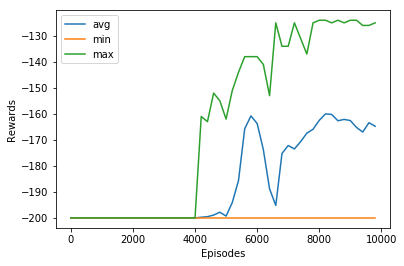

In [29]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

### 6. Rendering Test

In [30]:
done = False
state = env.reset()
while not done:
    action = np.argmax(q_table[get_discrete_state(state)])
    next_state, _, done, _ = env.step(action)
    state = next_state
    env.render()

env.close()